# Notebook 6: Experiment E3 - Feature Ablation Study

**Objective:**
Measure the contribution of each feature group to understand which types of signals are most valuable for regression detection.

**Approach:**
Train models on 4 different feature combinations:
1. **Only magnitude features** - Statistical signals (amount, t-value, prev/new values)
2. **Only context features** - Platform and test information (repository, framework, platform, suite)
3. **Magnitude + Context** - Combination of groups 1 and 2
4. **All features** - Including workflow hints (manually_created, status fields)

---

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, classification_report
)
import warnings
import sys
import os
sys.path.append(os.path.abspath('../src'))
from utils import load_data, get_xgb_model
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Preprocessed Data

In [2]:
# Load preprocessed data using utility function
df_preprocessed = load_data("../results/data/preprocessed_alerts.csv")

print(f"Dataset shape: {df_preprocessed.shape}")
print(f"\nColumns: {list(df_preprocessed.columns)}")
print(f"\nClass distribution:")
print(df_preprocessed['single_alert_is_regression'].value_counts())

Dataset shape: (17989, 19)

Columns: ['single_alert_amount_pct', 'single_alert_amount_abs', 'single_alert_t_value', 'alert_summary_status', 'single_alert_new_value', 'single_alert_prev_value', 'single_alert_status', 'single_alert_is_regression', 'single_alert_series_signature_tags_bytecode-cached, cold, fission, webrender', 'single_alert_series_signature_tags_bytecode-cached, fission, warm, webrender', 'single_alert_series_signature_tags_cold, fission, interactive, webrender', 'single_alert_series_signature_tags_cold, fission, webrender', 'single_alert_series_signature_tags_cold, webrender', 'single_alert_series_signature_tags_fission, warm, webrender', 'single_alert_series_signature_tags_fission, webrender', 'single_alert_series_signature_tags_warm, webrender', 'single_alert_series_signature_tags_webrender', 'single_alert_manually_created_True', 'single_alert_series_signature_suite_freq']

Class distribution:
single_alert_is_regression
0    10377
1     7612
Name: count, dtype: int64


## 3. Define Feature Groups

According to Phase 1 requirements, we categorize features into three groups:

In [3]:
# Get all columns except target
all_cols = [col for col in df_preprocessed.columns if col != 'single_alert_is_regression']

# Define feature groups based on Phase 1 requirements
# Group 1: Magnitude and statistical signals (numeric)
magnitude_features = [
    'single_alert_amount_abs',
    'single_alert_amount_pct', 
    'single_alert_t_value',
    'single_alert_prev_value',
    'single_alert_new_value'
]

# Filter to only include features that exist in the dataset
magnitude_features = [f for f in magnitude_features if f in all_cols]

# Group 2: Test and platform context (categorical) 
# These are the encoded versions from preprocessing
context_features = []
context_keywords = [
    'repository', 'framework', 'machine_platform', 
    'suite', 'platform', 'test'
]

for col in all_cols:
    if any(keyword in col.lower() for keyword in context_keywords):
        if col not in magnitude_features:
            context_features.append(col)

# Group 3: Workflow hints
workflow_features = []
workflow_keywords = [
    'manually_created', 'status', 'starred', 
    'classifier', 'noise_profile'
]

for col in all_cols:
    if any(keyword in col.lower() for keyword in workflow_keywords):
        if col not in magnitude_features and col not in context_features:
            workflow_features.append(col)

# Features that don't fit into above categories (will be excluded)
other_features = []
for col in all_cols:
    if (col not in magnitude_features and 
        col not in context_features and 
        col not in workflow_features):
        other_features.append(col)

print("="*70)
print("FEATURE GROUP DEFINITIONS")
print("="*70)
print(f"\n1. MAGNITUDE FEATURES ({len(magnitude_features)} features):")
for f in magnitude_features:
    print(f"   - {f}")

print(f"\n2. CONTEXT FEATURES ({len(context_features)} features):")
for f in context_features[:10]:  # Show first 10
    print(f"   - {f}")
if len(context_features) > 10:
    print(f"   ... and {len(context_features) - 10} more")

print(f"\n3. WORKFLOW FEATURES ({len(workflow_features)} features):")
for f in workflow_features:
    print(f"   - {f}")

print(f"\n4. OTHER FEATURES (excluded) ({len(other_features)} features):")
for f in other_features[:5]:
    print(f"   - {f}")
if len(other_features) > 5:
    print(f"   ... and {len(other_features) - 5} more")

FEATURE GROUP DEFINITIONS

1. MAGNITUDE FEATURES (5 features):
   - single_alert_amount_abs
   - single_alert_amount_pct
   - single_alert_t_value
   - single_alert_prev_value
   - single_alert_new_value

2. CONTEXT FEATURES (1 features):
   - single_alert_series_signature_suite_freq

3. WORKFLOW FEATURES (3 features):
   - alert_summary_status
   - single_alert_status
   - single_alert_manually_created_True

4. OTHER FEATURES (excluded) (9 features):
   - single_alert_series_signature_tags_bytecode-cached, cold, fission, webrender
   - single_alert_series_signature_tags_bytecode-cached, fission, warm, webrender
   - single_alert_series_signature_tags_cold, fission, interactive, webrender
   - single_alert_series_signature_tags_cold, fission, webrender
   - single_alert_series_signature_tags_cold, webrender
   ... and 4 more


## 4. Create 4 Feature Combinations

In [4]:
# Define the 4 combinations for ablation study
feature_combinations = {
    'Only Magnitude': magnitude_features,
    'Only Context': context_features,
    'Magnitude + Context': magnitude_features + context_features,
    'All Features': magnitude_features + context_features + workflow_features
}

print("FEATURE COMBINATIONS FOR EXPERIMENT E3")
print("="*70)
for name, features in feature_combinations.items():
    print(f"\n{name}: {len(features)} features")

FEATURE COMBINATIONS FOR EXPERIMENT E3

Only Magnitude: 5 features

Only Context: 1 features

Magnitude + Context: 6 features

All Features: 9 features


## 5. Prepare Train/Test Splits

We'll use the same split strategy for all experiments to ensure fair comparison.

In [5]:
# Prepare target variable
y = df_preprocessed['single_alert_is_regression'].astype(int)

# Calculate class balance
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

print(f"Class distribution:")
print(f"  Regression (1): {(y == 1).sum()}")
print(f"  Non-regression (0): {(y == 0).sum()}")
print(f"  Scale pos weight: {scale_pos_weight:.2f}")

Class distribution:
  Regression (1): 7612
  Non-regression (0): 10377
  Scale pos weight: 1.36


## 6. Train Models on Each Feature Combination

In [6]:
# Store results
results = []

print("="*70)
print("TRAINING MODELS FOR EACH FEATURE COMBINATION")
print("="*70)

for combo_name, features in feature_combinations.items():
    print(f"\n{'='*70}")
    print(f"Experiment: {combo_name}")
    print(f"Features: {len(features)}")
    print(f"{'='*70}")
    
    # Prepare features
    X = df_preprocessed[features]
    
    # Train/test split (70/30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=42
    )
    
    print(f"Train set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Train XGBoost model (using same hyperparameters as main experiment)
    # Train XGBoost model using utility function
    model = get_xgb_model(scale_pos_weight)
    
    print(f"\nTraining model...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'Combination': combo_name,
        'Num_Features': len(features),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    
    results.append(metrics)
    
    # Print results
    print(f"\nResults:")
    print(f"  Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall:    {metrics['Recall']:.4f}")
    print(f"  F1-Score:  {metrics['F1-Score']:.4f}")
    print(f"  ROC-AUC:   {metrics['ROC-AUC']:.4f}")

print(f"\n{'='*70}")
print("All experiments complete!")
print(f"{'='*70}")

TRAINING MODELS FOR EACH FEATURE COMBINATION

Experiment: Only Magnitude
Features: 5
Train set: (12592, 5)
Test set: (5397, 5)

Training model...



Results:
  Accuracy:  0.9911
  Precision: 0.9891
  Recall:    0.9899
  F1-Score:  0.9895
  ROC-AUC:   0.9985

Experiment: Only Context
Features: 1
Train set: (12592, 1)
Test set: (5397, 1)

Training model...



Results:
  Accuracy:  0.5707
  Precision: 0.4940
  Recall:    0.5941
  F1-Score:  0.5395
  ROC-AUC:   0.6069

Experiment: Magnitude + Context
Features: 6
Train set: (12592, 6)
Test set: (5397, 6)

Training model...



Results:
  Accuracy:  0.9976
  Precision: 0.9987
  Recall:    0.9956
  F1-Score:  0.9971
  ROC-AUC:   1.0000

Experiment: All Features
Features: 9
Train set: (12592, 9)
Test set: (5397, 9)

Training model...



Results:
  Accuracy:  0.9974
  Precision: 0.9974
  Recall:    0.9965
  F1-Score:  0.9969
  ROC-AUC:   1.0000

All experiments complete!


## 7. Compare Results

In [7]:
# Create resultsDataFrame
results_df = pd.DataFrame(results)

print("\nEXPERIMENT E3 - FEATURE ABLATION RESULTS")
print("="*70)
display(results_df)

# Find best performing combination for each metric
print("\n\nBest Performing Combinations:")
print("="*70)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = results_df[metric].idxmax()
    best_combo = results_df.loc[best_idx, 'Combination']
    best_value = results_df.loc[best_idx, metric]
    print(f"{metric:12s}: {best_combo:25s} ({best_value:.4f})")


EXPERIMENT E3 - FEATURE ABLATION RESULTS


,Combination,Num_Features,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Only Magnitude,5,0.991106,0.989064,0.989930,0.989497,0.998490
1,Only Context,1,0.570687,0.493993,0.594133,0.539455,0.606908
2,Magnitude + Context,6,0.997591,0.998682,0.995622,0.997150,0.999986
3,All Features,9,0.997406,0.997371,0.996497,0.996934,0.999982




Best Performing Combinations:
Accuracy    : Magnitude + Context       (0.9976)
Precision   : Magnitude + Context       (0.9987)
Recall      : All Features              (0.9965)
F1-Score    : Magnitude + Context       (0.9971)
ROC-AUC     : Magnitude + Context       (1.0000)


## 8. Visualize Performance Comparison

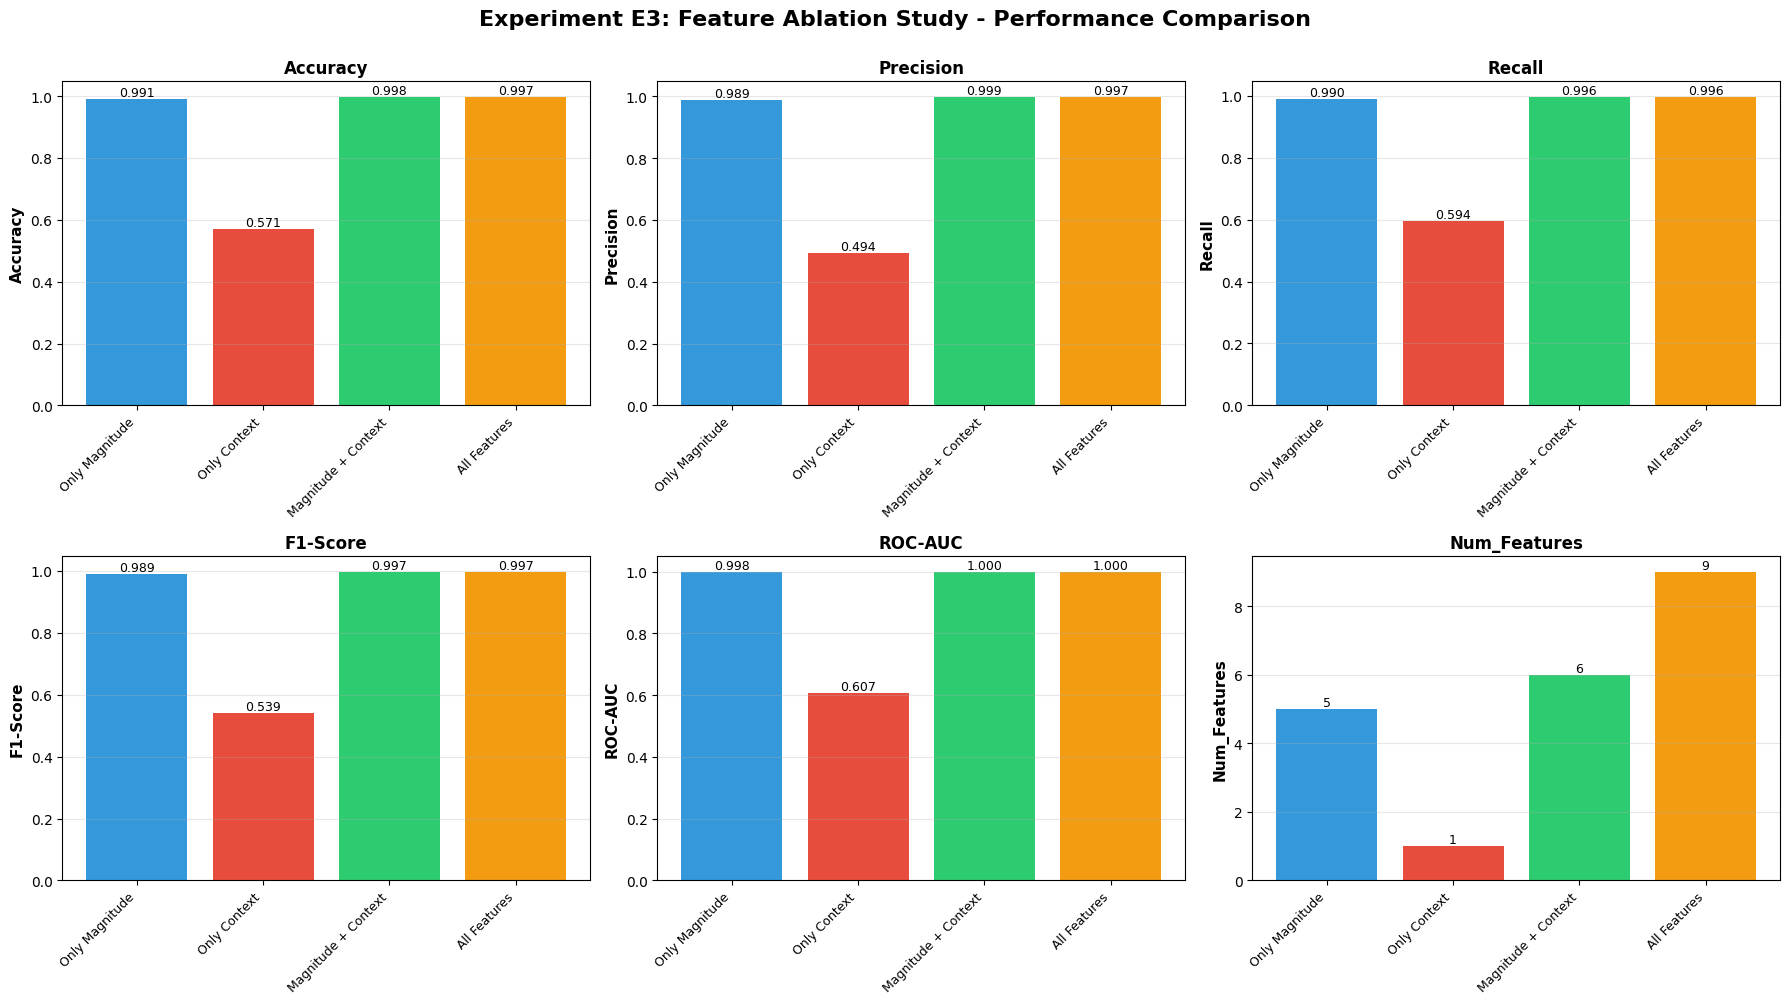

In [8]:
# Create bar chart comparing all metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Experiment E3: Feature Ablation Study - Performance Comparison', 
             fontsize=16, fontweight='bold', y=1.00)

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Num_Features']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    values = results_df[metric].values
    combinations = results_df['Combination'].values
    
    bars = ax.bar(range(len(combinations)), values, color=colors)
    ax.set_xticks(range(len(combinations)))
    ax.set_xticklabels(combinations, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if metric == 'Num_Features':
            label = f'{int(height)}'
        else:
            label = f'{height:.3f}'
        ax.text(bar.get_x() + bar.get_width()/2., height,
                label, ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../results/figures/ablation_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

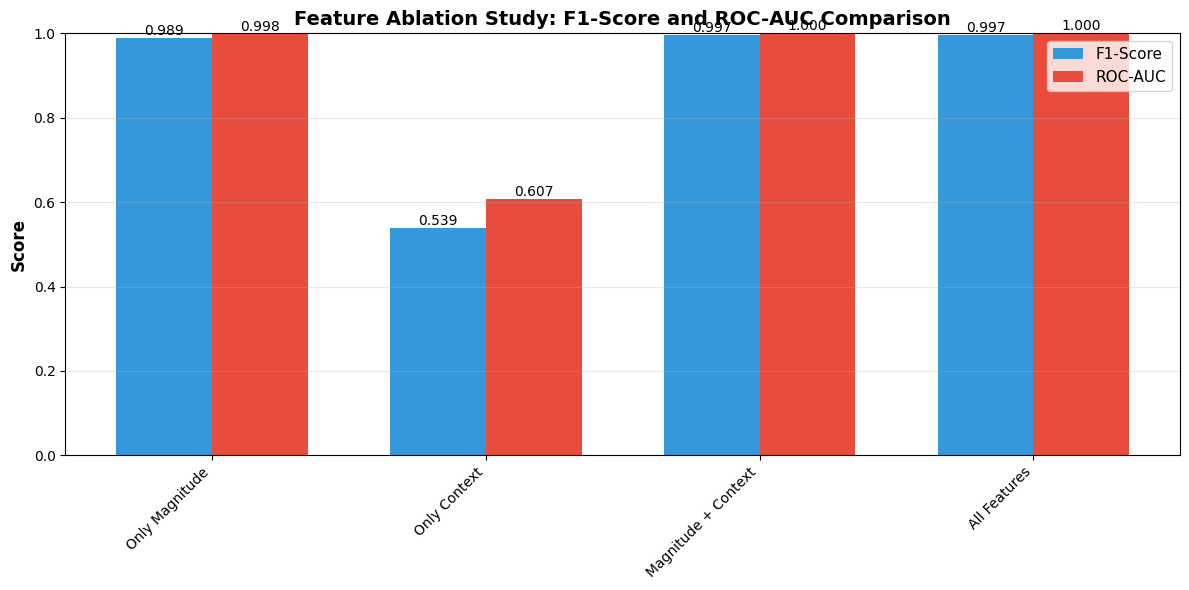

In [9]:
# Create focused comparison of F1 and ROC-AUC
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['F1-Score'], width, 
               label='F1-Score', color='#3498db')
bars2 = ax.bar(x + width/2, results_df['ROC-AUC'], width, 
               label='ROC-AUC', color='#e74c3c')

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Feature Ablation Study: F1-Score and ROC-AUC Comparison', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Combination'], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../results/figures/ablation_f1_rocauc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Key Findings

In [10]:
print("KEY FINDINGS - EXPERIMENT E3")
print("="*70)

# Get performance data
mag_only = results_df[results_df['Combination'] == 'Only Magnitude'].iloc[0]
ctx_only = results_df[results_df['Combination'] == 'Only Context'].iloc[0]
mag_ctx = results_df[results_df['Combination'] == 'Magnitude + Context'].iloc[0]
all_feat = results_df[results_df['Combination'] == 'All Features'].iloc[0]

print("\n1. Magnitude Features Performance:")
print(f"   F1-Score: {mag_only['F1-Score']:.4f}")
print(f"   ROC-AUC:  {mag_only['ROC-AUC']:.4f}")
print(f"   → Magnitude features alone provide {'strong' if mag_only['F1-Score'] > 0.8 else 'moderate'} predictive power")

print("\n2. Context Features Performance:")
print(f"   F1-Score: {ctx_only['F1-Score']:.4f}")
print(f"   ROC-AUC:  {ctx_only['ROC-AUC']:.4f}")
print(f"   → Context alone is {'sufficient' if ctx_only['F1-Score'] > 0.7 else 'insufficient'} for good predictions")

print("\n3. Combined Effect (Magnitude + Context):")
improvement_over_mag = mag_ctx['F1-Score'] - mag_only['F1-Score']
improvement_over_ctx = mag_ctx['F1-Score'] - ctx_only['F1-Score']
print(f"   F1-Score: {mag_ctx['F1-Score']:.4f}")
print(f"   Improvement over magnitude only: {improvement_over_mag:+.4f}")
print(f"   Improvement over context only: {improvement_over_ctx:+.4f}")

if improvement_over_mag > 0.01:
    print("   ✓ Context features add significant value to magnitude features")
else:
    print("   ~ Context features add minimal value to magnitude features")

print("\n4. All Features (Including Workflow):")
workflow_benefit = all_feat['F1-Score'] - mag_ctx['F1-Score']
print(f"   F1-Score: {all_feat['F1-Score']:.4f}")
print(f"   Additional improvement from workflow: {workflow_benefit:+.4f}")

if workflow_benefit > 0.01:
    print("   ✓ Workflow features provide additional predictive value")
elif workflow_benefit > -0.01:
    print("   ~ Workflow features have minimal impact")
else:
    print("   ✗ Workflow features may introduce noise or overfitting")

# Determine best approach
print("\n5. Recommendation:")
best_f1 = results_df['F1-Score'].max()
best_combo = results_df[results_df['F1-Score'] == best_f1]['Combination'].values[0]
print(f"   Best performing combination: {best_combo}")
print(f"   F1-Score: {best_f1:.4f}")

if best_combo == 'All Features':
    print("   → Use all available features for optimal performance")
elif best_combo == 'Magnitude + Context':
    print("   → Magnitude and context features are sufficient")
    print("   → Workflow features can be excluded for simplicity")
elif best_combo == 'Only Magnitude':
    print("   → Magnitude features dominate - context may not be necessary")
else:
    print("   → Unexpected result - requires further investigation")

print("\n" + "="*70)

KEY FINDINGS - EXPERIMENT E3

1. Magnitude Features Performance:
   F1-Score: 0.9895
   ROC-AUC:  0.9985
   → Magnitude features alone provide strong predictive power

2. Context Features Performance:
   F1-Score: 0.5395
   ROC-AUC:  0.6069
   → Context alone is insufficient for good predictions

3. Combined Effect (Magnitude + Context):
   F1-Score: 0.9971
   Improvement over magnitude only: +0.0077
   Improvement over context only: +0.4577
   ~ Context features add minimal value to magnitude features

4. All Features (Including Workflow):
   F1-Score: 0.9969
   Additional improvement from workflow: -0.0002
   ~ Workflow features have minimal impact

5. Recommendation:
   Best performing combination: Magnitude + Context
   F1-Score: 0.9971
   → Magnitude and context features are sufficient
   → Workflow features can be excluded for simplicity



## 10. Save Results

In [11]:
# Save results to CSV
results_df.to_csv('../results/metrics/ablation_study_results.csv', index=False)

# Create a detailed report
with open('../results/reports/ablation_study_report.txt', 'w') as f:
    f.write("EXPERIMENT E3: FEATURE ABLATION STUDY\n")
    f.write("="*70 + "\n\n")
    
    f.write("OBJECTIVE:\n")
    f.write("Measure the contribution of different feature groups to regression detection\n\n")
    
    f.write("FEATURE GROUPS:\n")
    f.write(f"1. Magnitude features: {len(magnitude_features)} features\n")
    f.write(f"2. Context features: {len(context_features)} features\n")
    f.write(f"3. Workflow features: {len(workflow_features)} features\n\n")
    
    f.write("RESULTS:\n")
    f.write(results_df.to_string(index=False))
    f.write("\n\n")
    
    f.write("BEST PERFORMING COMBINATION:\n")
    best_idx = results_df['F1-Score'].idxmax()
    f.write(f"  {results_df.loc[best_idx, 'Combination']}\n")
    f.write(f"  F1-Score: {results_df.loc[best_idx, 'F1-Score']:.4f}\n")
    f.write(f"  ROC-AUC: {results_df.loc[best_idx, 'ROC-AUC']:.4f}\n")

print("Results saved to results/ directory")
print("\nFiles created:")
print("  - ablation_study_results.csv")
print("  - ablation_study_report.txt")
print("  - ablation_performance_comparison.png")
print("  - ablation_f1_rocauc_comparison.png")
print("\nExperiment E3 complete!")

Results saved to results/ directory

Files created:
  - ablation_study_results.csv
  - ablation_study_report.txt
  - ablation_performance_comparison.png
  - ablation_f1_rocauc_comparison.png

Experiment E3 complete!
